SVG Path instructions: https://www.w3schools.com/graphics/svg_path.asp
Bezier curves to biarcs: http://dlacko.org/blog/2016/10/19/approximating-bezier-curves-by-biarcs/

In [2]:
import re
import pandas as pd
import numpy as np
import math

In [3]:
# read svg and find paths
f = open("picassodog.svg", "r")
svg = "".join(f.readlines())
paths = re.findall(r"path\s*d=\"(.+?)\"", svg)

In [4]:
# to keep track of how many parameters an instruction needs 
num_param = {"m": 2, "l": 2, "h": 1, "v": 1, "z": 0,
            "c": 6, "s": 4, "q": 4, "t": 2, "a": 7}

In [5]:
# split svg path into its individual components
def split_path(path):
    ins = ""
    
    while len(path) > 0:
        #print path
        
        # if the first element is a letter, it is the instruction
        if path[0].isalpha():
            ins = path[0]
            path = path[1:]
            path = path.strip()
        
        # get number of necessary parameters
        n = str(num_param[ins.lower()])

        # split into part for this instruction and rest
        res = re.search(r"((?:[\-\d\.]+[\s\,]*){"+n+"})(.*)", path)
        
        # collect parameters and the remaining path
        params = res.group(1).strip()
        path = res.group(2).strip()
        
        # split parameters into individual numbers
        params = re.split(r"[,\s]", params)
        params = [float(p) for p in params]
        
        if ins == "m":
            ins = "M"
        
        # reorder the parameters
        yield [ins] + params[-2:] + params[:-2]

In [23]:
def is_clockwise(P1x, P1y, C1x, C1y, C2x, C2y, P2x, P2y):
    sum = 0
    sum += (C1x - P1x) * (C1y + P1y)
    sum += (C2x - C1x) * (C2y + C1y)
    sum += (P2x - C2x) * (P2y + C2y)
    sum += (P1x - P2x) * (P1y + P2y)
    return sum > 0

def dist(ax, ay, bx, by):
    return math.sqrt((ax-bx)**2 + (ay-by)**2)

def intersection_point(P1x, P1y, C1x, C1y,
                       P2x, P2y, C2x, C2y):
    # calculates the intersection point of the lines through
    # P1 and C1: t*P1 + (1-t) * C1
    # P2 and C2: u*P2 + (1-u) * C2
    # solution is based on simple algebra
    a = P1x - C1x
    b = P1y - C1y

    u = (a*(C2y-C1y) - b*(C2x-C1x)) / (a*(C2y-P2y) - b*(C2x-P2x))
    #t = (u*P2x + (1-u)*C2x - C1x) / (P1x-C1x)

    Vx = u*P2x + (1-u)*C2x
    Vy = u*P2y + (1-u)*C2y
    
    return Vx, Vy

def cubic_bezier_to_circles(P1x, P1y, P2x, P2y, C1x, C1y, C2x, C2y):
    # based on:
    # http://dlacko.org/blog/2016/10/19/approximating-bezier-curves-by-biarcs/
        
    # calculate V: the intersection point of the line between P1 and C1 with the line between P2 and C2
    Vx, Vy = intersection_point(P1x, P1y, C1x, C1y, P2x, P2y, C2x, C2y)

    print(Vx, Vy)

    # calculate G: the incenter point of the triangle P1, P2 and V
    # https://en.wikipedia.org/wiki/Incenter#Cartesian_coordinates

    # determine lengths of sides opposite the points
    lP1 = dist(P2x, P2y, Vx, Vy)
    lP2 = dist(P1x, P1y, Vx, Vy)
    lV  = dist(P1x, P1y, P2x, P2y)

    # the incenter point is the weighted average of the points with these lenghts
    Gx = (lP1*P1x + lP2*P2x + lV*Vx) / (lP1 + lP2 + lV)
    Gy = (lP1*P1y + lP2*P2y + lV*Vy) / (lP1 + lP2 + lV)

    print(Gx, Gy)

    # We know the tangent at P1.
    # Q1 lies on the line which is perpendicular to this tangent
    #  and goes through P1, let’s denote it by P1Q.
    # If we take the section between P1 and G,
    #  its perpendicular bisector (EQ1) intersects with P1Q at Q1.
    # The same method can be used to find Q2.

    # calculate the perpendicular bisectors
    E1x = 0.5*P1x + 0.5*Gx
    E1y = 0.5*P1y + 0.5*Gy

    E2x = 0.5*P2x + 0.5*Gx
    E2y = 0.5*P2y + 0.5*Gy
    
    print(E1x, E1y)
    print(E2x, E2y)

    # find a point on the line perpendicular to the tangent through P1
    U1x = C1y - P1y
    U1y = P1x - C1x
    # the same for P2
    U2x = C2y - P2y
    U2y = P2x - C2x

    # find a point on the perpendicular bisectors
    T1x = E1x + (Gy - E1y)
    T1y = E1y + (E1x - Gx)
    # find a point on the perpendicular bisectors
    T2x = E2x + (Gy - E2y)
    T2y = E2y + (E2x - Gx)

    # find the centers and radii of the circles by intersecting the lines
    Q1x, Q1y = intersection_point(P1x, P1y, U1x, U1y,
                                  E1x, E1y, T1x, T1y)
    rad1 = dist(Q1x, Q1y, P1x, P1y)

    Q2x, Q2y = intersection_point(P2x, P2y, U2x, U2y,
                                  E2x, E2y, T2x, T2y)
    rad2 = dist(Q2x, Q2y, P2x, P2y)
    
    cw = is_clockwise(P1x, P1y, C1x, C1y, C2x, C2y, P2x, P2y)
    
    return Q1x, Q1y, Q2x, Q2y, Gx, Gy, cw

In [24]:
def clean_df(df):
    # flip y coordinates (we want (0,0) in the bottom left)
    df[["y", "C1y", "C2y"]] = -df[["y", "C1y", "C2y"]]

    # convert everything to absolute paths
    df["is_abs"] = df["ins"].apply(lambda x: x.isupper())
    df["group"] = df["is_abs"].cumsum()

    # add the relative paths to the absolute paths
    df["P2x"] = df.groupby("group").x.cumsum()
    df["P2y"] = df.groupby("group").y.cumsum()

    # shift y coordinate such that the origin is in (0,0)
    df.loc[df["is_abs"], "C1y"] -= df["P2y"].min()
    df.loc[df["is_abs"], "C2y"] -= df["P2y"].min()
    df["P2y"] -= df["P2y"].min()

    # add 'from' coordinates such that every row in the DataFrame is stand-alone
    df["P1x"] = df["P2x"].shift(1)
    df["P1y"] = df["P2y"].shift(1)
    df.loc[0, "P1x"] = 0
    df.loc[0, "P1y"] = 0

    # make these absolute as well
    df.loc[-df["is_abs"], "C1x"] += df["P1x"]
    df.loc[-df["is_abs"], "C1y"] += df["P1y"]
    df.loc[-df["is_abs"], "C2x"] += df["P1x"]
    df.loc[-df["is_abs"], "C2y"] += df["P1y"]

    # make sure that these are in uppercase
    df["ins"] = df["ins"].str.upper()

    df = df[["ins", "P1x", "P1y", "P2x", "P2y", "C1x", "C1y", "C2x", "C2y"]]
    
    return df

In [25]:
def normalize_df(df, xlim = 100., ylim = 100., margin = 5.):
    # make sure that x and y are between 0 and xlim, ylim
    # with a margin
    # make sure everything is larger than 0
    xmin = df[["P1x", "P2x", "C1x", "C2x"]].min().min()
    df[["P1x", "P2x", "C1x", "C2x"]] -= xmin

    ymin = df[["P1y", "P2y", "C1y", "C2y"]].min().min()
    df[["P1y", "P2y", "C1y", "C2y"]] -= ymin

    # make sure everything is less than xlim - 2*margin
    xmax = df[["P1x", "P2x", "C1x", "C2x"]].max().max()
    xmul = (xlim-2*margin) / xmax

    ymax = df[["P1y", "P2y", "C1y", "C2y"]].max().max()
    ymul = (ylim-2*margin) / ymax

    df[["P1x", "P1y", "P2x", "P2y", "C1x", "C1y", "C2x", "C2y"]] *= min(xmul, ymul)

    # shift everything up by margin
    df[["P1x", "P1y", "P2x", "P2y", "C1x", "C1y", "C2x", "C2y"]] += margin

    return df

In [26]:
def path_to_df(path):
    records = split_path(path)
    cols = ["ins", "x", "y", "C1x", "C1y", "C2x", "C2y"]
    df = pd.DataFrame.from_records(records, columns = cols)
    
    df = clean_df(df)
    
    df = normalize_df(df)
    
    return df

In [27]:
# loop over paths in svg
for path in paths:
    df = path_to_df(path)

In [28]:
df.loc[1, ["P1x", "P1y", "P2x", "P2y", "C1x", "C1y", "C2x", "C2y"]]

P1x    28.7033
P1y          5
P2x    31.8048
P2y    15.0393
C1x    29.8584
C1y    11.6205
C2x    30.8922
C2y    14.9669
Name: 1, dtype: object

In [30]:
cubic_bezier_to_circles(*df.loc[1, ["P1x", "P1y", "P2x", "P2y", "C1x", "C1y", "C2x", "C2y"]])

(30.435910123764742, 14.930772331784166)
(30.955908724883891, 14.359663955085685)
(29.829585272797203, 9.6798319775428432)
(31.38033359317814, 14.699481770710792)


(38.235152938146555,
 7.656813195027623,
 31.290666834045904,
 14.811473551851121,
 30.955908724883891,
 14.359663955085685,
 True)

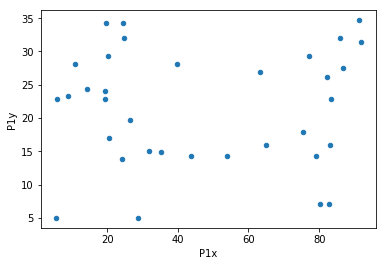

In [76]:
# preview
%matplotlib inline
df.plot.scatter(x = "P1x", y = "P1y")

In [80]:
import plotter

# Open grbl serial port
p = plotter.Plotter(port = '/dev/tty.wchusbserial1420',
                    baud = 115200,
                    speed = 1000)

G21
> ok
F1000
> ok


In [86]:
df.loc[8, ["P1x", "P1y", "P2x", "P2y", "C1x", "C1y", "C2x", "C2y"]]

P1x    79.0703
P1y    14.2675
P2x     80.307
P2y    7.09014
C1x     79.307
C1y     11.718
C2x    79.1476
C2y    8.96809
Name: 8, dtype: object

In [78]:
for i, row in df.iterrows():
    if row["ins"] == "M":
        #print "G01 X{} Y{}".format(*row[["P2x", "P2y"]])
        p.move(*row[["P2x", "P2y"]])
        p.pen_down()
    elif row["ins"] == "C":
        P1x, P1y, P2x, P2y, C1x, C1y, C2x, C2y = row[["P1x", "P1y", "P2x", "P2y", "C1x", "C1y", "C2x", "C2y"]]
        Q1x, Q1y, Q2x, Q2y, Gx, Gy, cw = cubic_bezier_to_circles(P1x, P1y, P2x, P2y, C1x, C1y, C2x, C2y)
        # first make a circle arc from (P1x, P1y) to (Gx, Gy)
        # I,J are relative paths
        
        
        #print "G02 X{} Y{} I{} J{}".format(Gx, Gy, Q1x-P1x, Q1y-P1y)
        p.arc(Gx, Gy, Q1x-P1x, Q1y-P1y, cw)
        
        # then from (Gx, Gy) to (P2x, P2y)
        #print "G02 X{} Y{} I{} J{}".format(P2x, P2y, Q2x-Gx, Q2y-Gy)
        p.arc(P2x, P2y, Q2x-Gx, Q2y-Gy, cw)
    else:
        print row
    a = raw_input()
    if a == "n":
        break

G01 X-28.7032618207 Y5.0
> ok
S1000 M3
> ok

G03 X-30.9559087249 Y14.3596639551 I-9.53189111744 J2.65681319503
> ok
G03 X-31.8047584615 Y15.0392995863 I-0.334758109162 J0.451809596765
> ok

G03 X-33.591113194 Y15.0816719888 I-0.882839411132 J0.457018347442
> ok
G03 X-35.2285910988 Y14.9307723022 I-0.78311238082 J-0.462049212782
> ok

G02 X-41.3446885523 Y14.2232473051 I-3.28210044714 J1.58302017646
> ok
G02 X-43.6882987921 Y14.2675312633 I-1.17809450777 J-0.310707080375
> ok

G03 X-44.6191918821 Y14.3215964243 I-0.45793913577 J0.15629503429
> ok
G03 X-53.8593813817 Y14.2675312633 I-4.61585914567 J-0.750932851222
> ok

G02 X-59.2979259184 Y14.8648387823 I-2.65462471632 J0.887276169133
> ok
G02 X-65.0457884377 Y15.8995844378 I-2.87567329873 J0.507696052484
> ok

G03 X-74.8717608852 Y17.9100217988 I-4.78686238488 J1.621646424
> ok
G03 X-75.5038730782 Y17.9356404526 I-0.317862499058 J-0.031761675573
> ok

G03 X-77.9261218074 Y16.7495051943 I-1.75187557358 J0.511219524988
> ok
G03 X-79.0703

SerialException: read failed: [Errno 6] Device not configured

In [82]:
# Close serial port
p.stop()

S0 M5


SerialException: Attempting to use a port that is not open

In [87]:
import pygame

ImportError: No module named pygame